In [1]:
import clr
import random
import ctypes
import numpy as np
import pandas as pd
import plotnine as pn
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
clr.AddReference(r'C:\Daten\Python\Python Integration\SMCWrapper\SMCWrapper\SMCWrapper\bin\x64\Debug\SMCWrapper')
from Calculator import Calculator
library = Calculator()

In [3]:
clr.Python

<module 'Python'>

In [27]:
total_length = 100000
nr_signals = 10
data = np.hstack([np.random.poisson(40,total_length-nr_signals),np.random.poisson(100,nr_signals)]).astype(np.float)
np.random.shuffle(data)

In [28]:
res=0
threshold = 0
library.addPhotonData(data, total_length, res, threshold)

(0, 66, 71)

In [18]:
def calc_DE(total_length,nr_signals, mean_noise,mean_signal):
    #data = np.hstack([np.random.poisson(mean_noise,total_length-nr_signals),np.random.poisson(mean_noise+mean_signal,nr_signals)]).astype(np.float)
    #np.random.shuffle(data)
    #with fixed signal heigth
    data = np.random.poisson(mean_noise,total_length)
    indices = np.random.randint(0,total_length,nr_signals)
    data[indices] += int(mean_signal)
    res = 0
    de = library.addPhotonData(data, total_length, res)[1]
    de_normalized = de/(600000/total_length)
    return de_normalized
    
    

In [6]:
vectorized_calc_DE = np.vectorize(calc_DE,otypes = [np.float])

In [7]:
vectorized_calc_DE(100000,1,1,np.arange(10))

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [246]:
a = np.arange(10)

In [247]:
a+a

array([ 0,  2,  4,  6,  8, 10, 12, 14, 16, 18])

In [276]:
df = pd.DataFrame([],columns = ["mean_noise","mean_signal","DE_recovery"])

In [277]:
df.append([1,2,3],axis = 1)

TypeError: append() got an unexpected keyword argument 'axis'

In [8]:
result = 0
pd.DataFrame([],columns = ["mean_noise","mean_signal"])
result_list = []
total_length = 100000
for mean_noise in tqdm(np.linspace(1,50,20)):
    for mean_signal in np.linspace(1,50,20):
        for fraction in np.logspace(-4,-1,10):#konzentrationsrange von 1fM bis 600fM
            for i in range(10):
                fraction = np.round(fraction,4)
                nr_events = int(total_length*fraction)
                de=vectorized_calc_DE(total_length,nr_events,mean_noise,mean_signal)
                de_recovery = de / nr_events
                result_list.append({key:value for key,value in zip(["mean_noise","mean_signal","signal_fraction","DE_recovery"],[mean_noise,mean_signal,fraction,de_recovery])})

100%|███████████████████████████████████████████████████████████████████████████████| 20/20 [2:36:04<00:00, 468.22s/it]


In [9]:
result = pd.DataFrame(result_list)
result_mean = result.groupby(["mean_noise","mean_signal","signal_fraction"]).mean().reset_index()
result_sd = result.groupby(["mean_noise","mean_signal","signal_fraction"]).std().reset_index()

In [19]:
recovery_vs_signal = pn.ggplot(result_mean,pn.aes("mean_signal","DE_recovery",color="mean_noise",group="mean_noise"))+pn.geom_line()+\
pn.facet_wrap("signal_fraction")+pn.facet_wrap("signal_fraction")+pn.theme(figure_size=(10,10))

In [21]:
recovery_vs_signal.save("recovery_vs_signal.png")

C:\Users\peterdietiker\AppData\Local\Continuum\anaconda3\envs\Grifols\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 10 x 10 in image.
  from_inches(height, units), units), PlotnineWarning)
C:\Users\peterdietiker\AppData\Local\Continuum\anaconda3\envs\Grifols\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: recovery_vs_signal.png
  warn('Filename: {}'.format(filename), PlotnineWarning)


In [20]:
recovery_vs_noise = pn.ggplot(result_mean,pn.aes("mean_noise","DE_recovery",color="mean_signal",group="mean_signal"))+pn.geom_line()+\
pn.facet_wrap("signal_fraction")+pn.theme(figure_size=(10,10))

In [22]:
recovery_vs_noise.save("recovery_vs_noise.png")

C:\Users\peterdietiker\AppData\Local\Continuum\anaconda3\envs\Grifols\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 10 x 10 in image.
  from_inches(height, units), units), PlotnineWarning)
C:\Users\peterdietiker\AppData\Local\Continuum\anaconda3\envs\Grifols\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: recovery_vs_noise.png
  warn('Filename: {}'.format(filename), PlotnineWarning)


In [357]:
def calc_DE_normal(total_length,nr_signals, mean_noise,mean_signal):
    #data = np.hstack([np.random.poisson(mean_noise,total_length-nr_signals),np.random.poisson(mean_noise+mean_signal,nr_signals)]).astype(np.float)
    #np.random.shuffle(data)
    #with fixed signal heigth
    data = np.clip(np.random.normal(mean_noise,mean_noise/8,total_length).astype(np.int),0,None)
    indices = np.random.randint(0,total_length,nr_signals)
    data[indices] += int(mean_signal)
    res = 0
    de = library.addPhotonData(data, total_length, res)[1]
    de_normalized = de/(600000/total_length)
    return de_normalized

In [361]:
result = 0
pd.DataFrame([],columns = ["mean_noise","mean_signal"])
result_list = []
nr_events = 100
total_length = 100000
for mean_noise in np.linspace(1,100,10):
    for mean_signal in np.linspace(1,100,10):
        for i in range(10):
            de=calc_DE_normal(100000,100,mean_noise,mean_signal)
            de_recovery = de / nr_events
            result_list.append({key:value for key,value in zip(["mean_noise","mean_signal","DE_recovery"],[mean_noise,mean_signal,de_recovery])})

In [362]:
result_normal = pd.DataFrame(result_list)
result_mean_normal = result_normal.groupby(["mean_noise","mean_signal"]).mean().reset_index()
result_sd_normal = result_normal.groupby(["mean_noise","mean_signal"]).std().reset_index()

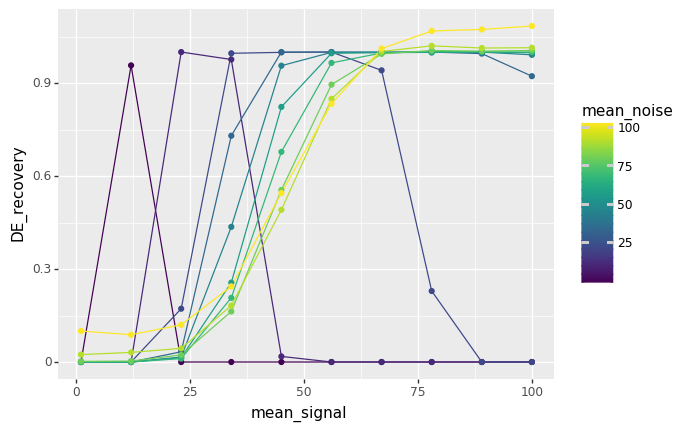

<ggplot: (162680172727)>

In [363]:
pn.ggplot(result_mean_normal,pn.aes("mean_signal","DE_recovery",color="mean_noise",group="mean_noise"))+pn.geom_line()+pn.geom_point()

In [ ]:
result_normal

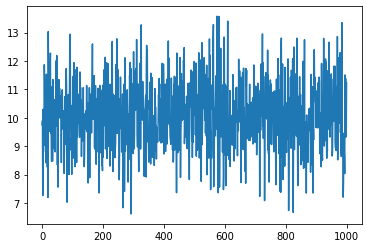

In [350]:
result = 0
pd.DataFrame([],columns = ["mean_noise","mean_signal"])
result_list = []
nr_events = 100
total_length = 100000
for mean_noise in np.linspace(1,100,20):
    for mean_signal in np.linspace(1,100,20):
        for i in range(10):
            de=vectorized_calc_DE(100000,100,mean_noise,mean_signal)
            de_recovery = de / nr_events
            result_list.append({key:value for key,value in zip(["mean_noise","mean_signal","DE_recovery"],[mean_noise,mean_signal,de_recovery])})

In [341]:
np.random.normal(10,10,100)

array([ 14.41090196,  13.65087305,   4.01839707,   7.96321173,
         5.99633797,   7.05735435,  20.31959945,   3.27073263,
         9.14254857,  18.88541704,  -0.72787921,  18.46635542,
        -6.72077413,  16.07490809,   0.08229021,  10.51495177,
        -5.2458931 ,  13.38293542,   5.90960832,  14.96355319,
         1.53170648,   8.70414018,   9.31426948,   2.10831826,
         4.13439115,  -1.95313678,  11.84825369,  16.07074759,
       -14.48172043,  16.4228705 ,  10.77652885,  25.14811446,
        -0.76975651,  15.96047252,  -2.87736193,  20.63404031,
        -5.54381384,   2.33269282, -14.93404942,  25.95756941,
        24.41055004,   6.30177443,  15.82027726,  28.84385413,
         4.64184103,  12.93410298,   4.38907158,  27.17118065,
         4.84720409,   4.49098258,   3.64551829,  26.94359087,
        26.87045897,  17.80867009,  19.11889814,   6.87057448,
        15.11960484,  -4.48931455,  -4.18680052,   6.22871597,
        15.79786688,  -9.46744741,  12.87430689,  26.07

In [151]:
np.repeat(100,10)

array([100, 100, 100, 100, 100, 100, 100, 100, 100, 100])

In [180]:
from sklearn.metrics import roc_curve, auc

In [ ]:
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [181]:
??roc_curve

In [282]:
numOfRows = 2
row_list = []
for i in range (0,5):
    row_list.append(dict( (a,np.random.randint(100)) for a in ['A','B','C','D','E']))
for i in range( 1,numOfRows-4):
    dict1 = dict( (a,np.random.randint(100)) for a in ['A','B','C','D','E'])
    row_list.append(dict1)

In [280]:
numOfRows = 2
row_list = []
for i in range (0,5):
    row_list.append(dict( (a,np.random.randint(100)) for a in ['A','B','C','D','E']))

In [283]:
row_list

[{'A': 7, 'B': 78, 'C': 68, 'D': 28, 'E': 47},
 {'A': 99, 'B': 97, 'C': 9, 'D': 50, 'E': 21},
 {'A': 62, 'B': 30, 'C': 57, 'D': 55, 'E': 8},
 {'A': 84, 'B': 79, 'C': 19, 'D': 84, 'E': 69},
 {'A': 48, 'B': 25, 'C': 98, 'D': 59, 'E': 31}]

In [24]:
a = pd.DataFrame({"a":np.arange(100)})

In [26]:
type(a["a"].values)

numpy.ndarray

In [27]:
len(a["a"])

100